In [1]:
import torch
import torchvision
import json
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

In [2]:
df=pd.read_csv("C:/Users/rprat/OneDrive/Desktop/MMA Documents/MGSC 673 - Intro to AI/Bank Customer Churn Prediction.csv")

## Part 1: Data Exploration

In [3]:
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df.dtypes

customer_id           int64
credit_score          int64
country              object
gender               object
age                   int64
tenure                int64
balance             float64
products_number       int64
credit_card           int64
active_member         int64
estimated_salary    float64
churn                 int64
dtype: object

In [5]:
df.describe()

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [6]:
df.describe(include=["object"])

,country,gender
count,10000,10000
unique,3,2
top,France,Male
freq,5014,5457


In [7]:
df.isna().any()

customer_id         False
credit_score        False
country             False
gender              False
age                 False
tenure              False
balance             False
products_number     False
credit_card         False
active_member       False
estimated_salary    False
churn               False
dtype: bool

The female churn rate is 25.07 %.
The male churn rate is 16.46 %.


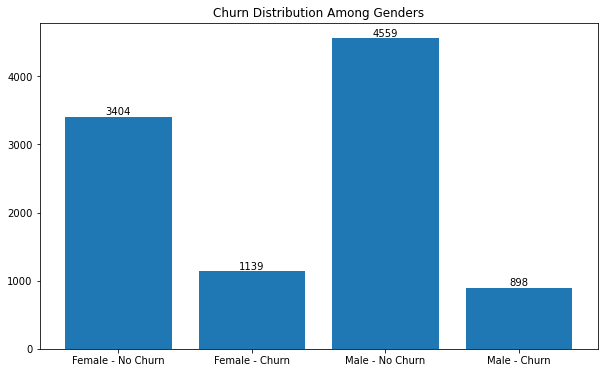

In [8]:
genderchurn=df.groupby(["gender", "churn"]).size().reset_index(name="count")
genderchurn["gender"]=["Female - No Churn","Female - Churn","Male - No Churn","Male - Churn"]

fig, ax=plt.subplots(figsize=(10,6))
plt.bar(genderchurn["gender"],genderchurn["count"])

plt.title("Churn Distribution Among Genders")

for i in range(4):
    ax.text(genderchurn["gender"].iloc[i], genderchurn["count"].iloc[i], str(genderchurn["count"].iloc[i]), ha='center', va='bottom')
    
print("The female churn rate is", round((genderchurn["count"].iloc[1]/(genderchurn["count"].iloc[1]+genderchurn["count"].iloc[0])*100),2),"%.")
print("The male churn rate is", round((genderchurn["count"].iloc[3]/(genderchurn["count"].iloc[2]+genderchurn["count"].iloc[3])*100),2),"%.")

The churn rate in France is 16.15 %.
The churn rate in Germany is 32.44 %.
The churn rate in Spain is 16.67 %.


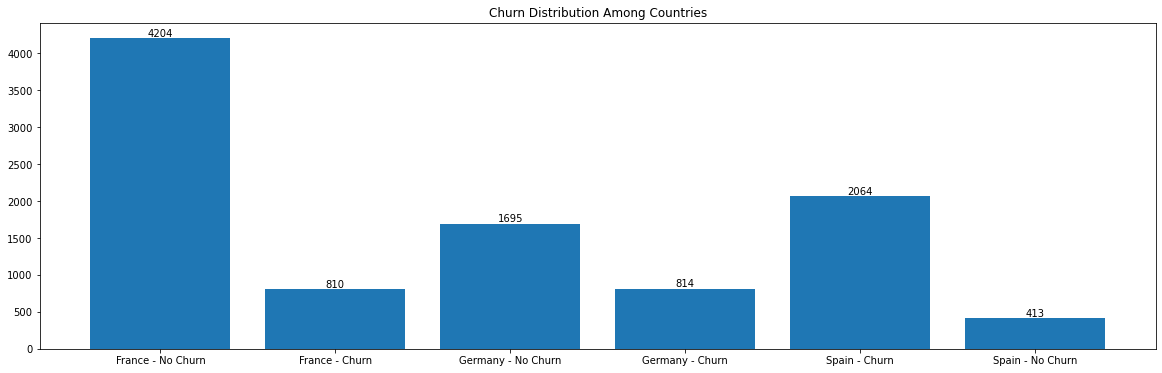

In [9]:
countrychurn=df.groupby(["country", "churn"]).size().reset_index(name="count")
countrychurn["country"]=["France - No Churn","France - Churn","Germany - No Churn","Germany - Churn", "Spain - Churn", "Spain - No Churn"]

fig, ax=plt.subplots(figsize=(20,6))
plt.bar(countrychurn["country"],countrychurn["count"])

plt.title("Churn Distribution Among Countries")

for i in range(6):
    ax.text(countrychurn["country"].iloc[i], countrychurn["count"].iloc[i], str(countrychurn["count"].iloc[i]), ha='center', va='bottom')

print("The churn rate in France is", round((countrychurn["count"].iloc[1]/(countrychurn["count"].iloc[1]+countrychurn["count"].iloc[0])*100),2),"%.")
print("The churn rate in Germany is", round((countrychurn["count"].iloc[3]/(countrychurn["count"].iloc[2]+countrychurn["count"].iloc[3])*100),2),"%.")
print("The churn rate in Spain is", round((countrychurn["count"].iloc[5]/(countrychurn["count"].iloc[4]+countrychurn["count"].iloc[5])*100),2),"%.")

## Part 2: Data Preparation

In [10]:
#Separate target from predictors
x=df.drop(["customer_id","churn"],axis=1)
y=df["churn"]

In [11]:
#Dummify categorical variables
encoder=LabelEncoder()
x.gender=encoder.fit_transform(x.gender)
x.country=encoder.fit_transform(x.country)

In [12]:
x=x.values
y=y.values

In [13]:
def train_val_test_split(X, y, train_size):
    """Split dataset into data splits."""
    X_train, X_, y_train, y_ = train_test_split(X, y, train_size=0.7, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.5, stratify=y_)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [14]:
#Split train and test
xtrain, xval, xtest, ytrain, yval, ytest=train_val_test_split(X=x, y=y, train_size=0.7)

In [15]:
#Standardize data
xscaler=MinMaxScaler(feature_range=(0,1))
xscaler=xscaler.fit(xtrain)

xtrain=xscaler.transform(xtrain)
xtest=xscaler.transform(xtest)

In [16]:
#Convert data to tensors
xtrain = torch.Tensor(xtrain)
ytrain = torch.LongTensor(ytrain)
ytrain=ytrain.float()
xval=torch.Tensor(xval)
yval=torch.LongTensor(yval)
yval=yval.float()
xtest = torch.Tensor(xtest)
ytest = torch.LongTensor(ytest)
ytest=ytest.flatten().tolist()

## Part 3A: Setting Up Parameter Experimentation

### Architectures to be considered

In [17]:
input_size=10 #there are 10 features
output_size=1 #binary classification

#Methods for deciding number of hidden neurons

#Method 1: Simplest neural network architecture
h1=1

#Method 2: The number of dimensions needed to capture at least 70% of the variance of the input data
from sklearn.decomposition import PCA
X_std = (x - x.mean()) / x.std()
# Perform PCA
pca = PCA()
pca.fit(X_std)
# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
h2 = np.argmax(cumulative_variance_ratio >= 0.7) + 1  # =2

#Method 3: Somewhere between the size of the input and output
h3=5

#Method 4: 2/3 the size of the input + the output
h4=8

#Method 5: Less than half the size of double the input 
h5=19 

#Method 6: The number of samples in the training set (~7000) divided by 2 times input+output
h6=round(7000/(2*(10+1))) #=318

H=[h1,h2,h3,h4,h5,h6]

In [18]:
H

[1, 2, 5, 8, 19, 318]

### Activation functions to be considered

The most pertinent activation functions for binary classification problems are:

- Sigmoid

- Tanh

### Learning rates to be considered

Learning rates can automatically be adjusted using gradient descent functions such as:

- RMSprop

- Adam

## Part 3B: Model Development & Testing

In [19]:
#Accuracy
def accuracy_fn(y_pred, y_true):
    n_correct = torch.eq(y_pred, y_true).sum().item()
    accuracy = (n_correct / len(y_pred)) * 100
    return accuracy

In [20]:
#Performance Evaluator
from sklearn.metrics import precision_recall_fscore_support
def get_performance(y_true, y_pred, classes):
    """Per-class performance metrics."""
    # Performance
    performance = {"overall": {}, "class": {}}

    # Overall performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance["overall"]["precision"] = round(metrics[0],2)
    performance["overall"]["recall"] = round(metrics[1],2)
    performance["overall"]["f1"] = round(metrics[2],2)

    # Per-class performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average=None)
    for i in range(len(classes)):
        performance["class"][classes[i]] = {
            "precision": metrics[0][i],
            "recall": metrics[1][i],
            "f1": metrics[2][i],
            "num_samples": np.float64(metrics[3][i]),
        }

    return performance

In [21]:
counts = np.bincount(ytrain)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}

Model 1: FNN with Sigmoid activiation & RMSprop

In [22]:
class FNN_with_Sigmoid(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FNN_with_Sigmoid, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.sigmoid = nn.Sigmoid()
        self.output = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.sigmoid(x)
        return x

In [23]:
neuron_performance_dict={}
for h in H:
    model=FNN_with_Sigmoid(input_size, h, output_size)
    class_weights_tensor = torch.Tensor(list(class_weights.values()))
    loss_function=nn.BCELoss()
    optimizer=torch.optim.RMSprop(model.parameters(), lr=0.001)
    losses=[]
    
    best_val_loss = float('inf')
    patience = 10  # Number of epochs to wait for improvement
    num_epochs = 100
    no_improvement = 0

    for epoch in range(10):
        #Forward pass
        ypred = model(xtrain)

        #Loss
        ypred=ypred[:,0]
        loss = loss_function(ypred, ytrain)
        losses.append(loss.item())

        #Zero all gradients
        optimizer.zero_grad()

        #Backward pass
        loss.backward()

        #Update weights
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            val_outputs = model(xval)
            val_outputs=val_outputs[:,0]
            val_loss = loss_function(val_outputs, yval)

        #Training progress
        if epoch%1==0: 
            predicted=(ypred>=0.5).float()
            accuracy=(predicted==ytrain).float().mean()
            print (f"Epoch: {epoch} | loss: {loss:.2f}, Accuracy: {accuracy.item():.2f}")
        
        #Implement early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement = 0
        else:
            no_improvement += 1
            if no_improvement >= patience:
                print("Early stopping triggered!")
                break
        
    #Final performances
    ypred = model(xtest)
    ypred = ypred.max(dim=1)[1]
    ypred=ypred.flatten().tolist()

    accuracy = {"accuracy": round(accuracy.item(),2)}
    average_loss={"average loss": round((sum(losses)/len(losses)))}
    performance=get_performance(y_true=ytest, y_pred=ypred, classes=[0,1])
    overall=next(iter(performance.items()))[1]
    overall={**accuracy,**overall, **average_loss}

    neuron_performance_dict[str(h)+ " Neurons"]=overall

neuron_performance_df_model1=pd.DataFrame(neuron_performance_dict)
neuron_performance_df_model1.columns.name="Model 1: FNN with Sigmoid Activation & RMSprop"

Epoch: 0 | loss: 0.51, Accuracy: 0.80
Epoch: 1 | loss: 0.50, Accuracy: 0.80
Epoch: 2 | loss: 0.50, Accuracy: 0.80
Epoch: 3 | loss: 0.50, Accuracy: 0.80
Epoch: 4 | loss: 0.50, Accuracy: 0.80
Epoch: 5 | loss: 0.50, Accuracy: 0.80
Epoch: 6 | loss: 0.50, Accuracy: 0.80
Epoch: 7 | loss: 0.50, Accuracy: 0.80
Epoch: 8 | loss: 0.50, Accuracy: 0.80
Epoch: 9 | loss: 0.50, Accuracy: 0.80
Epoch: 0 | loss: 0.54, Accuracy: 0.80
Epoch: 1 | loss: 0.54, Accuracy: 0.80
Epoch: 2 | loss: 0.53, Accuracy: 0.80
Epoch: 3 | loss: 0.53, Accuracy: 0.80
Epoch: 4 | loss: 0.53, Accuracy: 0.80
Epoch: 5 | loss: 0.53, Accuracy: 0.80
Epoch: 6 | loss: 0.53, Accuracy: 0.80
Epoch: 7 | loss: 0.53, Accuracy: 0.80
Epoch: 8 | loss: 0.53, Accuracy: 0.80
Epoch: 9 | loss: 0.53, Accuracy: 0.80
Epoch: 0 | loss: 0.80, Accuracy: 0.20
Epoch: 1 | loss: 0.78, Accuracy: 0.20
Epoch: 2 | loss: 0.77, Accuracy: 0.20
Epoch: 3 | loss: 0.76, Accuracy: 0.20
Epoch: 4 | loss: 0.75, Accuracy: 0.20
Epoch: 5 | loss: 0.74, Accuracy: 0.20
Epoch: 6 | l

C:\Users\rprat\OneDrive\Documents\New folder\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rprat\OneDrive\Documents\New folder\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rprat\OneDrive\Documents\New folder\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

Epoch: 8 | loss: 0.51, Accuracy: 0.80
Epoch: 9 | loss: 0.51, Accuracy: 0.80
Epoch: 0 | loss: 0.68, Accuracy: 0.70
Epoch: 1 | loss: 0.52, Accuracy: 0.80


C:\Users\rprat\OneDrive\Documents\New folder\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rprat\OneDrive\Documents\New folder\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 | loss: 0.51, Accuracy: 0.80
Epoch: 3 | loss: 0.51, Accuracy: 0.80
Epoch: 4 | loss: 0.51, Accuracy: 0.80
Epoch: 5 | loss: 0.51, Accuracy: 0.80
Epoch: 6 | loss: 0.50, Accuracy: 0.80
Epoch: 7 | loss: 0.50, Accuracy: 0.80
Epoch: 8 | loss: 0.50, Accuracy: 0.80
Epoch: 9 | loss: 0.50, Accuracy: 0.80


C:\Users\rprat\OneDrive\Documents\New folder\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rprat\OneDrive\Documents\New folder\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model 2: FNN with Sigmoid Activation & Adam

In [24]:
neuron_performance_dict={}
for h in H:
    model=FNN_with_Sigmoid(input_size, h, output_size)
    class_weights_tensor = torch.Tensor(list(class_weights.values()))
    loss_function=nn.BCELoss() 
    optimizer=torch.optim.Adam(model.parameters(), lr=0.001)
    losses=[]
    
    best_val_loss = float('inf')
    patience = 10  # Number of epochs to wait for improvement
    num_epochs = 100
    no_improvement = 0

    for epoch in range(10):
        #Forward pass
        ypred = model(xtrain)

        #Loss
        ypred=ypred[:,0]
        loss = loss_function(ypred, ytrain)
        losses.append(loss.item())

        #Zero all gradients
        optimizer.zero_grad()

        #Backward pass
        loss.backward()

        #Update weights
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            val_outputs = model(xval)
            val_outputs=val_outputs[:,0]
            val_loss = loss_function(val_outputs, yval)

        #Training progress
        if epoch%1==0: 
            predicted=(ypred>=0.5).float()
            accuracy=(predicted==ytrain).float().mean()
            print (f"Epoch: {epoch} | loss: {loss:.2f}, Accuracy: {accuracy.item():.2f}")
        
        #Implement early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement = 0
        else:
            no_improvement += 1
            if no_improvement >= patience:
                print("Early stopping triggered!")
                break
        
    #Final performances
    ypred = model(xtest)
    ypred = ypred.max(dim=1)[1]
    ypred=ypred.flatten().tolist()

    accuracy = {"accuracy": round(accuracy.item(),2)}
    average_loss={"average loss": round((sum(losses)/len(losses)))}
    performance=get_performance(y_true=ytest, y_pred=ypred, classes=[0,1])
    overall=next(iter(performance.items()))[1]
    overall={**accuracy,**overall,**average_loss}

    neuron_performance_dict[str(h)+ " Neurons"]=overall

neuron_performance_df_model2=pd.DataFrame(neuron_performance_dict)
neuron_performance_df_model2.columns.name="Model 2: FNN with Sigmoid Activation & Adam"

C:\Users\rprat\OneDrive\Documents\New folder\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rprat\OneDrive\Documents\New folder\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rprat\OneDrive\Documents\New folder\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

Epoch: 0 | loss: 0.56, Accuracy: 0.80
Epoch: 1 | loss: 0.56, Accuracy: 0.80
Epoch: 2 | loss: 0.56, Accuracy: 0.80
Epoch: 3 | loss: 0.56, Accuracy: 0.80
Epoch: 4 | loss: 0.56, Accuracy: 0.80
Epoch: 5 | loss: 0.56, Accuracy: 0.80
Epoch: 6 | loss: 0.56, Accuracy: 0.80
Epoch: 7 | loss: 0.56, Accuracy: 0.80
Epoch: 8 | loss: 0.56, Accuracy: 0.80
Epoch: 9 | loss: 0.56, Accuracy: 0.80
Epoch: 0 | loss: 0.57, Accuracy: 0.80
Epoch: 1 | loss: 0.57, Accuracy: 0.80
Epoch: 2 | loss: 0.57, Accuracy: 0.80
Epoch: 3 | loss: 0.57, Accuracy: 0.80
Epoch: 4 | loss: 0.57, Accuracy: 0.80
Epoch: 5 | loss: 0.57, Accuracy: 0.80
Epoch: 6 | loss: 0.57, Accuracy: 0.80
Epoch: 7 | loss: 0.57, Accuracy: 0.80
Epoch: 8 | loss: 0.57, Accuracy: 0.80
Epoch: 9 | loss: 0.57, Accuracy: 0.80
Epoch: 0 | loss: 0.57, Accuracy: 0.80
Epoch: 1 | loss: 0.57, Accuracy: 0.80
Epoch: 2 | loss: 0.57, Accuracy: 0.80
Epoch: 3 | loss: 0.57, Accuracy: 0.80
Epoch: 4 | loss: 0.57, Accuracy: 0.80
Epoch: 5 | loss: 0.57, Accuracy: 0.80
Epoch: 6 | l

C:\Users\rprat\OneDrive\Documents\New folder\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rprat\OneDrive\Documents\New folder\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 | loss: 0.62, Accuracy: 0.80
Epoch: 8 | loss: 0.62, Accuracy: 0.80
Epoch: 9 | loss: 0.62, Accuracy: 0.80
Epoch: 0 | loss: 0.77, Accuracy: 0.20
Epoch: 1 | loss: 0.71, Accuracy: 0.21
Epoch: 2 | loss: 0.66, Accuracy: 0.80
Epoch: 3 | loss: 0.62, Accuracy: 0.80
Epoch: 4 | loss: 0.59, Accuracy: 0.80
Epoch: 5 | loss: 0.56, Accuracy: 0.80
Epoch: 6 | loss: 0.54, Accuracy: 0.80
Epoch: 7 | loss: 0.52, Accuracy: 0.80
Epoch: 8 | loss: 0.51, Accuracy: 0.80
Epoch: 9 | loss: 0.51, Accuracy: 0.80


C:\Users\rprat\OneDrive\Documents\New folder\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rprat\OneDrive\Documents\New folder\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model 3: FNN with Tanh Activation & RMSprop

In [25]:
class FNN_with_Tanh(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FNN_with_Tanh, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size) #one hidden layer
        self.tanh = nn.Tanh()
        self.output = nn.Linear(hidden_size, output_size)
        self.tanh=nn.Tanh()
        
    def forward(self, x):
        x = self.hidden(x)
        x = self.tanh(x)
        x = self.output(x)
        x = self.tanh(x)
        return x

In [26]:
neuron_performance_dict={}
for h in H:
    model=FNN_with_Tanh(input_size, h, output_size)
    class_weights_tensor = torch.Tensor(list(class_weights.values()))
    loss_function=nn.CrossEntropyLoss() 
    optimizer=torch.optim.RMSprop(model.parameters(), lr=0.001)
    losses=[]
    
    best_val_loss = float('inf')
    patience = 10  # Number of epochs to wait for improvement
    num_epochs = 100
    no_improvement = 0

    for epoch in range(10):
        #Forward pass
        ypred = model(xtrain)

        #Loss
        ypred=ypred[:,0]
        loss = loss_function(ypred, ytrain)
        losses.append(loss.item())

        #Zero all gradients
        optimizer.zero_grad()

        #Backward pass
        loss.backward()

        #Update weights
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            val_outputs = model(xval)
            val_outputs=val_outputs[:,0]
            val_loss = loss_function(val_outputs, yval)

        #Training progress
        if epoch%1==0: 
            predicted=(ypred>=0.5).float()
            accuracy=(predicted==ytrain).float().mean()
            print (f"Epoch: {epoch} | loss: {loss:.2f}, Accuracy: {accuracy.item():.2f}")
        
        #Implement early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement = 0
        else:
            no_improvement += 1
            if no_improvement >= patience:
                print("Early stopping triggered!")
                break
        
    #Final performances
    ypred = model(xtest)
    ypred = ypred.max(dim=1)[1]
    ypred=ypred.flatten().tolist()

    accuracy = {"accuracy": round(accuracy.item(),2)}
    average_loss={"average loss": round((sum(losses)/len(losses)))}
    performance=get_performance(y_true=ytest, y_pred=ypred, classes=[0,1])
    overall=next(iter(performance.items()))[1]
    overall={**accuracy,**overall, **average_loss}

    neuron_performance_dict[str(h)+ " Neurons"]=overall

neuron_performance_df_model3=pd.DataFrame(neuron_performance_dict)
neuron_performance_df_model3.columns.name="Model 3: FNN with Tanh Activation & RMSprop"

Epoch: 0 | loss: 12604.42, Accuracy: 0.80
Epoch: 1 | loss: 12600.54, Accuracy: 0.80
Epoch: 2 | loss: 12597.52, Accuracy: 0.80
Epoch: 3 | loss: 12594.90, Accuracy: 0.80
Epoch: 4 | loss: 12592.53, Accuracy: 0.80
Epoch: 5 | loss: 12590.34, Accuracy: 0.80
Epoch: 6 | loss: 12588.29, Accuracy: 0.80
Epoch: 7 | loss: 12586.34, Accuracy: 0.80
Epoch: 8 | loss: 12584.49, Accuracy: 0.80
Epoch: 9 | loss: 12582.73, Accuracy: 0.80
Epoch: 0 | loss: 12698.86, Accuracy: 0.49
Epoch: 1 | loss: 12688.37, Accuracy: 0.45
Epoch: 2 | loss: 12681.72, Accuracy: 0.42
Epoch: 3 | loss: 12676.69, Accuracy: 0.40
Epoch: 4 | loss: 12672.58, Accuracy: 0.38
Epoch: 5 | loss: 12669.07, Accuracy: 0.36
Epoch: 6 | loss: 12665.99, Accuracy: 0.35


C:\Users\rprat\OneDrive\Documents\New folder\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rprat\OneDrive\Documents\New folder\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rprat\OneDrive\Documents\New folder\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

Epoch: 7 | loss: 12663.25, Accuracy: 0.33
Epoch: 8 | loss: 12660.77, Accuracy: 0.32
Epoch: 9 | loss: 12658.51, Accuracy: 0.31
Epoch: 0 | loss: 12607.14, Accuracy: 0.80
Epoch: 1 | loss: 12599.50, Accuracy: 0.80
Epoch: 2 | loss: 12594.09, Accuracy: 0.80
Epoch: 3 | loss: 12589.57, Accuracy: 0.80
Epoch: 4 | loss: 12585.58, Accuracy: 0.80
Epoch: 5 | loss: 12581.98, Accuracy: 0.80
Epoch: 6 | loss: 12578.65, Accuracy: 0.80
Epoch: 7 | loss: 12575.56, Accuracy: 0.80
Epoch: 8 | loss: 12572.65, Accuracy: 0.80
Epoch: 9 | loss: 12569.88, Accuracy: 0.80
Epoch: 0 | loss: 12594.13, Accuracy: 0.80
Epoch: 1 | loss: 12580.84, Accuracy: 0.80
Epoch: 2 | loss: 12571.49, Accuracy: 0.80
Epoch: 3 | loss: 12563.77, Accuracy: 0.80
Epoch: 4 | loss: 12557.00, Accuracy: 0.80
Epoch: 5 | loss: 12550.89, Accuracy: 0.80
Epoch: 6 | loss: 12545.29, Accuracy: 0.80
Epoch: 7 | loss: 12540.11, Accuracy: 0.80
Epoch: 8 | loss: 12535.28, Accuracy: 0.80
Epoch: 9 | loss: 12530.76, Accuracy: 0.80
Epoch: 0 | loss: 12657.56, Accurac

C:\Users\rprat\OneDrive\Documents\New folder\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rprat\OneDrive\Documents\New folder\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 | loss: 12646.39, Accuracy: 0.80
Epoch: 1 | loss: 12524.85, Accuracy: 0.80
Epoch: 2 | loss: 12486.59, Accuracy: 0.77
Epoch: 3 | loss: 12459.86, Accuracy: 0.80
Epoch: 4 | loss: 12439.62, Accuracy: 0.78
Epoch: 5 | loss: 12422.80, Accuracy: 0.80
Epoch: 6 | loss: 12408.78, Accuracy: 0.79
Epoch: 7 | loss: 12396.88, Accuracy: 0.81
Epoch: 8 | loss: 12386.55, Accuracy: 0.79
Epoch: 9 | loss: 12377.50, Accuracy: 0.81


C:\Users\rprat\OneDrive\Documents\New folder\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rprat\OneDrive\Documents\New folder\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model 4: FNN with Tanh Activation & Adam

In [27]:
neuron_performance_dict={}
for h in H:
    model=FNN_with_Tanh(input_size, h, output_size)
    class_weights_tensor = torch.Tensor(list(class_weights.values()))
    loss_function=nn.CrossEntropyLoss() 
    losses=[]
    optimizer=torch.optim.Adam(model.parameters(), lr=0.001)
    
    best_val_loss = float('inf')
    patience = 10  # Number of epochs to wait for improvement
    num_epochs = 100
    no_improvement = 0

    for epoch in range(10):
        #Forward pass
        ypred = model(xtrain)

        #Loss
        ypred=ypred[:,0]
        loss = loss_function(ypred, ytrain)
        losses.append(loss.item())

        #Zero all gradients
        optimizer.zero_grad()

        #Backward pass
        loss.backward()

        #Update weights
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            val_outputs = model(xval)
            val_outputs=val_outputs[:,0]
            val_loss = loss_function(val_outputs, yval)

        #Training progress
        if epoch%1==0: 
            predicted=(ypred>=0.5).float()
            accuracy=(predicted==ytrain).float().mean()
            print (f"Epoch: {epoch} | loss: {loss:.2f}, Accuracy: {accuracy.item():.2f}")
        
        #Implement early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement = 0
        else:
            no_improvement += 1
            if no_improvement >= patience:
                print("Early stopping triggered!")
                break
        
    #Final performances
    ypred = model(xtest)
    ypred = ypred.max(dim=1)[1]
    ypred=ypred.flatten().tolist()

    accuracy = {"accuracy": round(accuracy.item(),2)}
    average_loss={"average loss": round((sum(losses)/len(losses)))}
    performance=get_performance(y_true=ytest, y_pred=ypred, classes=[0,1])
    overall=next(iter(performance.items()))[1]
    overall={**accuracy,**overall,**average_loss}

    neuron_performance_dict[str(h)+ " Neurons"]=overall

neuron_performance_df_model4=pd.DataFrame(neuron_performance_dict)
neuron_performance_df_model4.columns.name="Model 4: FNN with Tanh Activation & Adam"

Epoch: 0 | loss: 12626.30, Accuracy: 0.80
Epoch: 1 | loss: 12626.25, Accuracy: 0.80
Epoch: 2 | loss: 12626.20, Accuracy: 0.80
Epoch: 3 | loss: 12626.15, Accuracy: 0.80
Epoch: 4 | loss: 12626.10, Accuracy: 0.80
Epoch: 5 | loss: 12626.06, Accuracy: 0.80
Epoch: 6 | loss: 12626.01, Accuracy: 0.80
Epoch: 7 | loss: 12625.97, Accuracy: 0.80
Epoch: 8 | loss: 12625.93, Accuracy: 0.80
Epoch: 9 | loss: 12625.89, Accuracy: 0.80
Epoch: 0 | loss: 12602.66, Accuracy: 0.80
Epoch: 1 | loss: 12602.11, Accuracy: 0.80
Epoch: 2 | loss: 12601.56, Accuracy: 0.80
Epoch: 3 | loss: 12601.02, Accuracy: 0.80
Epoch: 4 | loss: 12600.47, Accuracy: 0.80
Epoch: 5 | loss: 12599.93, Accuracy: 0.80
Epoch: 6 | loss: 12599.38, Accuracy: 0.80
Epoch: 7 | loss: 12598.84, Accuracy: 0.80
Epoch: 8 | loss: 12598.30, Accuracy: 0.80
Epoch: 9 | loss: 12597.76, Accuracy: 0.80
Epoch: 0 | loss: 12647.75, Accuracy: 0.80
Epoch: 1 | loss: 12646.77, Accuracy: 0.80
Epoch: 2 | loss: 12645.79, Accuracy: 0.80
Epoch: 3 | loss: 12644.83, Accurac

C:\Users\rprat\OneDrive\Documents\New folder\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rprat\OneDrive\Documents\New folder\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rprat\OneDrive\Documents\New folder\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

Epoch: 4 | loss: 12654.96, Accuracy: 0.80
Epoch: 5 | loss: 12652.30, Accuracy: 0.80
Epoch: 6 | loss: 12649.66, Accuracy: 0.80
Epoch: 7 | loss: 12647.05, Accuracy: 0.80
Epoch: 8 | loss: 12644.47, Accuracy: 0.80
Epoch: 9 | loss: 12641.91, Accuracy: 0.80


C:\Users\rprat\OneDrive\Documents\New folder\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rprat\OneDrive\Documents\New folder\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 | loss: 12642.34, Accuracy: 0.80
Epoch: 1 | loss: 12624.74, Accuracy: 0.80
Epoch: 2 | loss: 12607.90, Accuracy: 0.80
Epoch: 3 | loss: 12591.70, Accuracy: 0.80
Epoch: 4 | loss: 12576.08, Accuracy: 0.80
Epoch: 5 | loss: 12561.07, Accuracy: 0.80
Epoch: 6 | loss: 12546.75, Accuracy: 0.80
Epoch: 7 | loss: 12533.29, Accuracy: 0.80
Epoch: 8 | loss: 12520.81, Accuracy: 0.80
Epoch: 9 | loss: 12509.39, Accuracy: 0.80


C:\Users\rprat\OneDrive\Documents\New folder\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rprat\OneDrive\Documents\New folder\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
neuron_performance_df_model1

Model 1: FNN with Sigmoid Activation & RMSprop,1 Neurons,2 Neurons,5 Neurons,8 Neurons,19 Neurons,318 Neurons
accuracy,0.80,0.80,0.20,0.80,0.80,0.80
precision,0.63,0.63,0.63,0.63,0.63,0.63
recall,0.80,0.80,0.80,0.80,0.80,0.80
f1,0.71,0.71,0.71,0.71,0.71,0.71
average loss,1.00,1.00,1.00,1.00,1.00,1.00


In [29]:
neuron_performance_df_model2

Model 2: FNN with Sigmoid Activation & Adam,1 Neurons,2 Neurons,5 Neurons,8 Neurons,19 Neurons,318 Neurons
accuracy,0.80,0.80,0.80,0.80,0.80,0.80
precision,0.63,0.63,0.63,0.63,0.63,0.63
recall,0.80,0.80,0.80,0.80,0.80,0.80
f1,0.71,0.71,0.71,0.71,0.71,0.71
average loss,1.00,1.00,1.00,1.00,1.00,1.00


In [30]:
neuron_performance_df_model3

Model 3: FNN with Tanh Activation & RMSprop,1 Neurons,2 Neurons,5 Neurons,8 Neurons,19 Neurons,318 Neurons
accuracy,0.80,0.31,0.80,0.80,0.80,0.81
precision,0.63,0.63,0.63,0.63,0.63,0.63
recall,0.80,0.80,0.80,0.80,0.80,0.80
f1,0.71,0.71,0.71,0.71,0.71,0.71
average loss,12592.00,12674.00,12585.00,12557.00,12595.00,12455.00


In [31]:
neuron_performance_df_model4

Model 4: FNN with Tanh Activation & Adam,1 Neurons,2 Neurons,5 Neurons,8 Neurons,19 Neurons,318 Neurons
accuracy,0.80,0.80,0.80,0.80,0.80,0.80
precision,0.63,0.63,0.63,0.63,0.63,0.63
recall,0.80,0.80,0.80,0.80,0.80,0.80
f1,0.71,0.71,0.71,0.71,0.71,0.71
average loss,12626.00,12600.00,12643.00,12616.00,12654.00,12571.00
